In [1]:
import json
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from constants import DATA_DIR
from scipy import stats
from sklearn.model_selection import KFold, train_test_split
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sns.set_theme()

In [2]:
FEATURES_DIR = DATA_DIR / "features"

In [3]:
feature_files = [file for file in FEATURES_DIR.iterdir() if file.suffix == ".json"]
len(feature_files)

192

In [4]:
class AsteroidData(TypedDict):
    is_failed: bool
    reason: str | None
    period: float
    processing_time: float
    features: np.ndarray

In [5]:
class AsteroidDataset(Dataset):
    def __init__(self, data: np.ndarray, targets: np.ndarray):
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [6]:
def create_dataloaders(X, y, batch_size=32, shuffle=True) -> DataLoader:
    dataset = AsteroidDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [7]:
class AsteroidPeriodPredictor(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(AsteroidPeriodPredictor, self).__init__()
        
        # Convolutional layers to capture local patterns
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
        )

        # LSTM to capture sequential dependencies
        self.lstm = nn.LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)

        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)

        # Fully connected layers for final prediction
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, 50, 2)
        batch_size, seq_len, _ = x.shape
        
        # Reshape for conv layers (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        
        x = self.conv_layers(x)  # Shape: (batch_size, 64, 50)
        
        # Reshape for LSTM (batch_size, seq_len, features)
        x = x.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, 50, 256)
        
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        pooled = torch.mean(attn_out, dim=1)  # Shape: (batch_size, 256)
        
        out = self.fc(pooled)
        
        return out.squeeze(-1)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def custom_loss(pred, target, input_freqs):
    mse_loss = F.mse_loss(pred, target)
    closest_freq_loss = torch.min(torch.abs(pred.unsqueeze(1) - input_freqs), dim=1)[0]
    return mse_loss + 0.1 * closest_freq_loss.mean()

In [41]:
def evaluate_test(model, test_loader, verbose: bool = True, ret_preds: bool = False):
    model.eval()
    test_loss = 0
    test_preds, test_targets = [], []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = custom_loss(outputs, targets, data[:, :, 0])
            test_loss += loss.item()
            test_preds.extend(outputs.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_loss /= len(test_loader)
    test_r2 = stats.pearsonr(test_targets, test_preds)[0] ** 2  # type: ignore
    test_mae = np.mean(np.abs(np.array(test_targets) - np.array(test_preds)))

    if verbose:
        indices = np.random.choice(len(test_preds), size=15, replace=False)

        sel_preds = 24 / np.array(test_preds)[indices]
        sel_targets = 24 / np.array(test_targets)[indices]

        for pred, target in zip(sel_preds, sel_targets):
            print(f"Pred: {pred:.3f} - Target: {target:.3f}")

        print(f"Test-loss: {test_loss:.4f}, Test-R2: {test_r2:.4f}, Test-MAE: {test_mae:.4f}")

    if ret_preds:
        return test_loss, float(test_r2), float(test_mae), test_preds, test_targets
    else:
        return test_loss, float(test_r2), float(test_mae)


def train_model(
    model,
    train_loader,
    test_loader,
    epochs=300,
    patience=25,
    verbose: bool = True,
    ret_preds: bool = False,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=15)

    best_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = custom_loss(outputs, targets, data[:, :, 0])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        train_r2 = stats.pearsonr(train_targets, train_preds)[0] ** 2  # type: ignore
        train_mae = np.mean(np.abs(np.array(train_targets) - np.array(train_preds)))

        scheduler.step(train_loss)

        if verbose:
            print(f"{epoch + 1:3}/{epochs} - ", end="")
            print(f"Train-loss: {train_loss:.4f}, Train-R2: {train_r2:.4f}, Train-MAE: {train_mae:.4f}")

        if train_loss < best_loss:
            best_loss = train_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            if verbose:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")

            break

    return evaluate_test(model, test_loader, verbose=verbose, ret_preds=ret_preds)

In [11]:
with open(feature_files[0], "r") as file:
    data = json.load(file)

config, asteroids_data = data["config"], data["asteroids"]

periods = [data["period"] for data in asteroids_data.values() if not data["is_failed"]]
print(f"Percentiles: {np.percentile(periods, [0, 5, 25, 50, 75, 85, 95, 100]).tolist()}")

max_period = 45
satisfying_asteroids = [data for data in asteroids_data.values() if not data["is_failed"] and data["period"] <= max_period]
print(
    f"If we cut-off asteroids with max period={max_period} we will have {len(satisfying_asteroids)} ({len(satisfying_asteroids) / len(periods):.4f}%) asteroids"
)

Percentiles: [2.39006, 3.49140205, 5.80871125, 8.47561, 13.877845, 17.872504999999997, 34.282899999999934, 748.7]
If we cut-off asteroids with max period=45 we will have 527 (0.9617%) asteroids


In [12]:
MAX_PERIOD = 40
VERBOSE = True


def process_dataset(feature_file, verbose: bool = False):
    with open(feature_file, "r") as f:
        loaded_data = json.load(f)

    asteroids_data = loaded_data["asteroids"]

    filtered_data = {
        name: AsteroidData(**data)
        for name, data in asteroids_data.items()
        if not data["is_failed"] and data["period"] <= MAX_PERIOD
    }

    clipped_data = []
    periods = []
    for data in filtered_data.values():
        arr = np.array(data["features"])

        idx = np.argsort(arr[:, :, 1].flatten())[::-1][:50]
        seq_idx, row_idx = np.unravel_index(idx, arr[:, :, 1].shape)

        clipped_data.append(arr[seq_idx, row_idx])
        periods.append(data["period"])

    clipped_data = np.array(clipped_data)
    periods = np.array(periods)

    # Convert periods to frequencies
    frequencies = 24 / periods

    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(clipped_data)):
        if verbose:
            print(f"Fold {fold+1}/{n_splits}")

        X_train, X_test = clipped_data[train_idx], clipped_data[test_idx]
        y_train, y_test = frequencies[train_idx], frequencies[test_idx]

        # Frequencies are always between 0 and 12 (data - min) / (max - min)
        X_train_normalized = X_train.copy()
        X_train_normalized[:, :, 0] /= 12

        X_test_normalized = X_test.copy()
        X_test_normalized[:, :, 0] /= 12

        train_loader = create_dataloaders(X_train_normalized, y_train)
        test_loader = create_dataloaders(X_test_normalized, y_test, shuffle=False)

        model = AsteroidPeriodPredictor().to(device)

        test_loss, test_r2, test_mae = train_model(model, train_loader, test_loader, epochs=300, patience=25, verbose=verbose)

        fold_results.append([test_loss, test_r2, test_mae])

    fold_losses = np.array(fold_results)[:, 0]

    dataset_result = {
        "min_loss": np.min(fold_losses),
        "max_loss": np.max(fold_losses),
        "mean_loss": np.mean(fold_losses),
        "std_loss": np.std(fold_losses),
        "median_loss": np.median(fold_losses),
        "fold_results": fold_results,
    }

    if verbose:
        print("-----------")
        print(f"Min validation loss: {dataset_result['min_loss']}")
        print(f"Max validation loss: {dataset_result['max_loss']}")
        print(f"Average validation loss: {dataset_result['mean_loss']}")
        print(f"Standard deviation: {dataset_result['std_loss']}")

    return dataset_result

In [13]:
dataset_results = []
for feature_file in tqdm(feature_files):
    dataset_result = process_dataset(feature_file)
    dataset_result["filename"] = feature_file.stem
    dataset_results.append(dataset_result)

 25%|██▌       | 48/192 [1:06:48<3:27:57, 86.65s/it]/tmp/ipykernel_15417/3369614278.py:63: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  test_r2 = stats.pearsonr(test_targets, test_preds)[0] ** 2  # type: ignore
 85%|████████▌ | 164/192 [3:57:07<40:29, 86.75s/it]   


KeyboardInterrupt: 

In [14]:
def compare_datasets(dataset_results, top_n=5, verbose: bool = True):
    sorted_datasets = sorted(dataset_results, key=lambda x: x["mean_loss"])

    top_n_datasets = sorted_datasets[:top_n]

    if verbose:
        print(f"Top {top_n} datasets:")
        for i, dataset in enumerate(top_n_datasets):
            print(f"Rank {i+1}: Dataset {dataset['filename']}")
            print(f"  Mean Loss: {dataset['mean_loss']:.4f}")
            print(f"  Std Dev: {dataset['std_loss']:.4f}")
            print(f"  Median Loss: {dataset['median_loss']:.4f}")
            print(f"  Min Loss: {dataset['min_loss']:.4f}")
            print(f"  Max Loss: {dataset['max_loss']:.4f}")
            print()

    return top_n_datasets

In [15]:
best_datasets = compare_datasets(dataset_results)
# print(f"The best performing dataset is Dataset {best_datasets[0]['filename']}")

Top 5 datasets:
Rank 1: Dataset asteroids_freq_data_89
  Mean Loss: 0.8249
  Std Dev: 0.1393
  Median Loss: 0.7796
  Min Loss: 0.6142
  Max Loss: 1.0060

Rank 2: Dataset asteroids_freq_data_75
  Mean Loss: 0.9461
  Std Dev: 0.1383
  Median Loss: 0.9425
  Min Loss: 0.7421
  Max Loss: 1.1473

Rank 3: Dataset asteroids_freq_data_96
  Mean Loss: 1.0132
  Std Dev: 0.1723
  Median Loss: 1.0500
  Min Loss: 0.7253
  Max Loss: 1.2582

Rank 4: Dataset asteroids_freq_data_91
  Mean Loss: 1.1072
  Std Dev: 0.3416
  Median Loss: 0.9168
  Min Loss: 0.7175
  Max Loss: 1.6203

Rank 5: Dataset asteroids_freq_data_29
  Mean Loss: 1.2134
  Std Dev: 0.4469
  Median Loss: 1.1378
  Min Loss: 0.6620
  Max Loss: 1.9948



In [16]:
with open(DATA_DIR / "dataset_results.json", "w") as file:
    json.dump(dataset_results, file, indent=4)

In [17]:
with open(DATA_DIR / "dataset_results.json", "r") as file:
    dataset_results = json.load(file)

In [24]:
def visualize_results(dataset_results, num_top_datasets=20):
    df = pd.DataFrame(dataset_results)
    df = df.sort_values("mean_loss").reset_index(drop=True)

    config_no = [int(name.split("_")[-1]) for name in df["filename"]]
    df["config_no"] = config_no

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x="mean_loss", y="std_loss", hue="config_no", palette="viridis", legend=False)
    plt.title("Mean Validation Loss vs Standard Deviation (All Datasets)")
    plt.xlabel("Mean Validation Loss")
    plt.ylabel("Standard Deviation of Validation Loss")
    plt.tight_layout()
    plt.show()


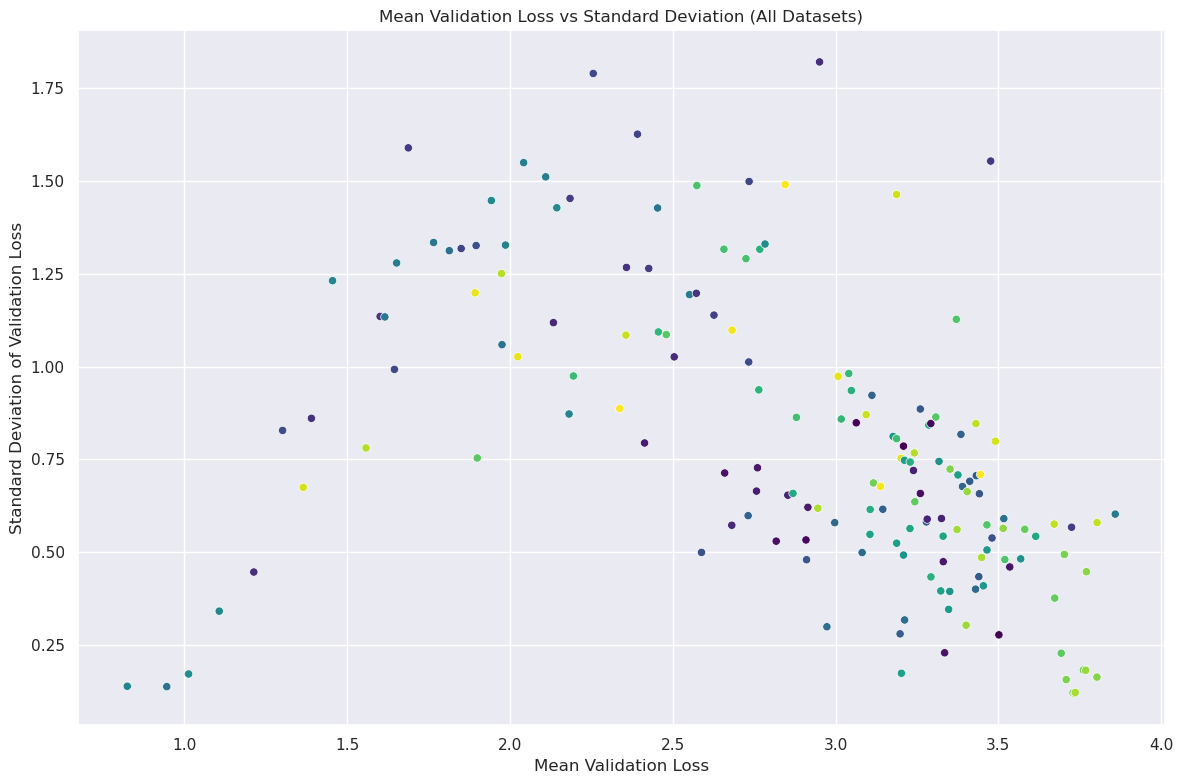

In [25]:
visualize_results(dataset_results, num_top_datasets=10)

In [42]:
def process_and_split_dataset(feature_file, test_size=0.1):
    with open(feature_file, "r") as f:
        loaded_data = json.load(f)

    asteroids_data = loaded_data["asteroids"]

    filtered_data = {
        name: AsteroidData(**data)
        for name, data in asteroids_data.items()
        if not data["is_failed"] and data["period"] <= MAX_PERIOD
    }

    clipped_data = []
    periods = []
    for data in filtered_data.values():
        arr = np.array(data["features"])

        idx = np.argsort(arr[:, :, 1].flatten())[::-1][:50]
        seq_idx, row_idx = np.unravel_index(idx, arr[:, :, 1].shape)

        clipped_data.append(arr[seq_idx, row_idx])
        periods.append(data["period"])

    clipped_data = np.array(clipped_data)
    periods = np.array(periods)

    frequencies = 24 / periods

    X_train, X_test, y_train, y_test = train_test_split(clipped_data, frequencies, test_size=test_size, random_state=88688)

    return X_train, X_test, y_train, y_test


def train_and_predict(feature_file, verbose: bool = True, ret_preds: bool = True):
    X_train, X_test, y_train, y_test = process_and_split_dataset(feature_file)

    X_train_normalized = X_train.copy()
    X_train_normalized[:, :, 0] /= 12

    X_test_normalized = X_test.copy()
    X_test_normalized[:, :, 0] /= 12

    train_loader = create_dataloaders(X_train_normalized, y_train)
    test_loader = create_dataloaders(X_test_normalized, y_test, shuffle=False)

    model = AsteroidPeriodPredictor().to(device)
    return train_model(
        model,
        train_loader,
        test_loader,
        epochs=300,
        patience=25,
        verbose=verbose,
        ret_preds=ret_preds,
    )


In [39]:
feature_file_path = "asteroids_freq_data_{}.json"

top_dataset_files = [FEATURES_DIR / f"{dataset['filename']}.json" for dataset in best_datasets]
top_dataset_files

[PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_89.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_75.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_96.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_91.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_29.json')]

In [45]:
for feature_file in top_dataset_files:
    with open(feature_file, "r") as f:
        data = json.load(f)
    
    print(f"\nDataset: {feature_file.stem}")
    print("----")
    print(data["config"])


Dataset: asteroids_freq_data_89
----
{'max_hours_diff': 2, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 60, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}

Dataset: asteroids_freq_data_75
----
{'max_hours_diff': 2, 'min_no_points': 20, 'top_k_bins': 2, 'buffer_bins': 3, 'select_bins_by': 'lightcurves', 'max_time_diff': 45, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}

Dataset: asteroids_freq_data_96
----
{'max_hours_diff': 2, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 60, 'min_bin_size': 2, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'max_debug': False}

Dataset: asteroids_freq_data_91
----
{'max_hours_diff': 2, 'min_no_points': 20, 'top_k_bins': 4, 'buffer_bins': 3, 'select_bins_by': 'points', 'max_time_diff': 30, 'min_bin_size': 1, 'max_freq': 12, 'top_k_freqs': 50, 'nterms': 3, 'm

In [47]:
plt.rcParams["figure.figsize"] = (12, 8)

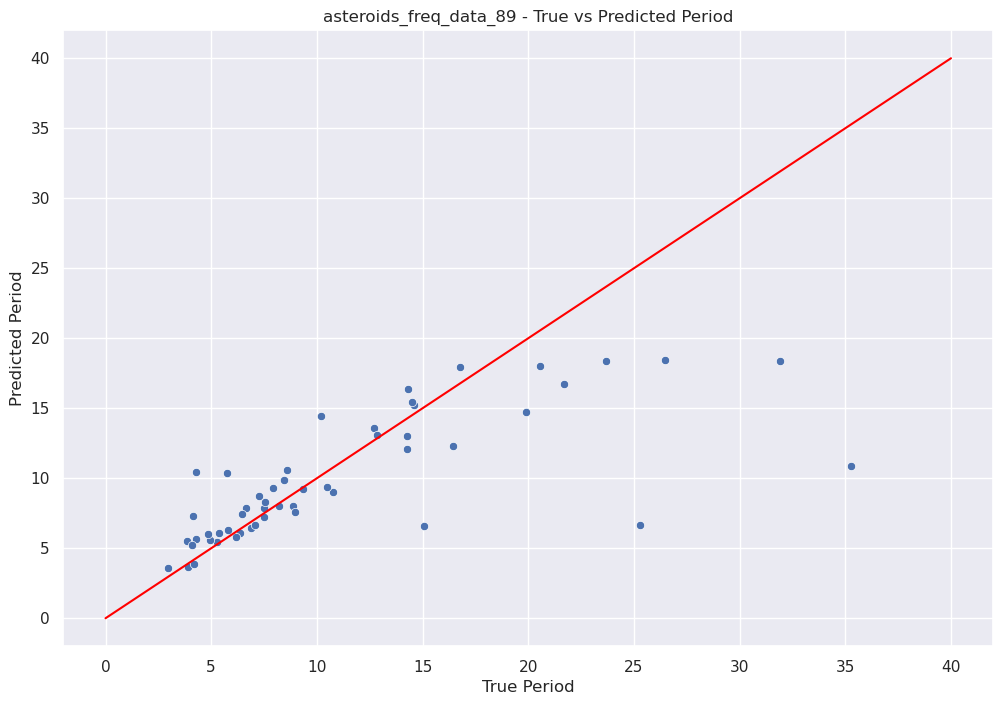

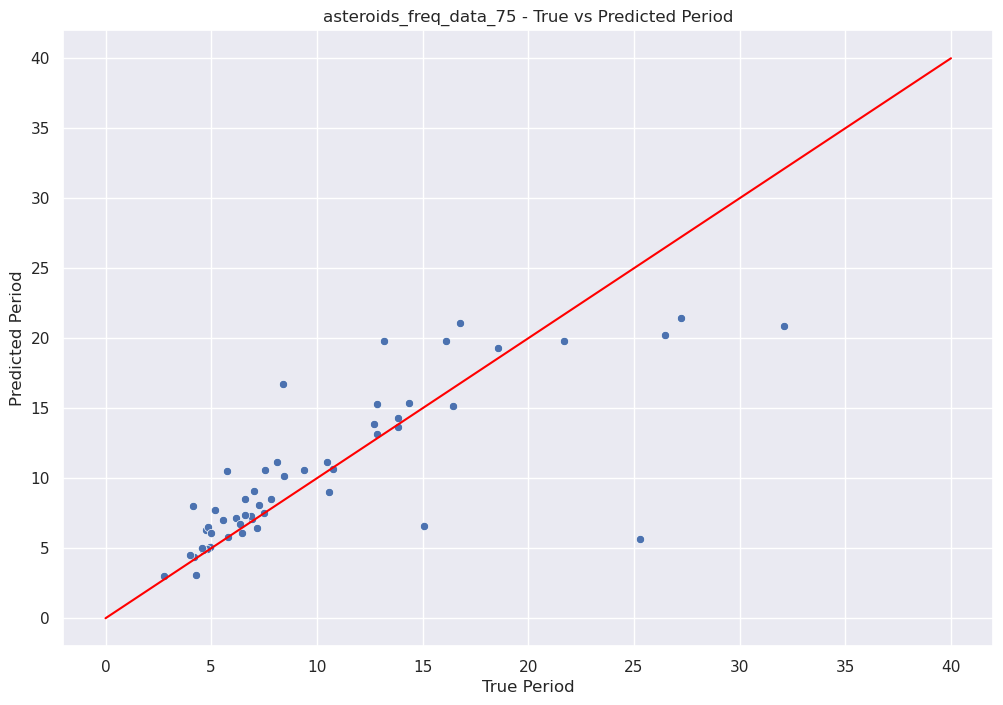

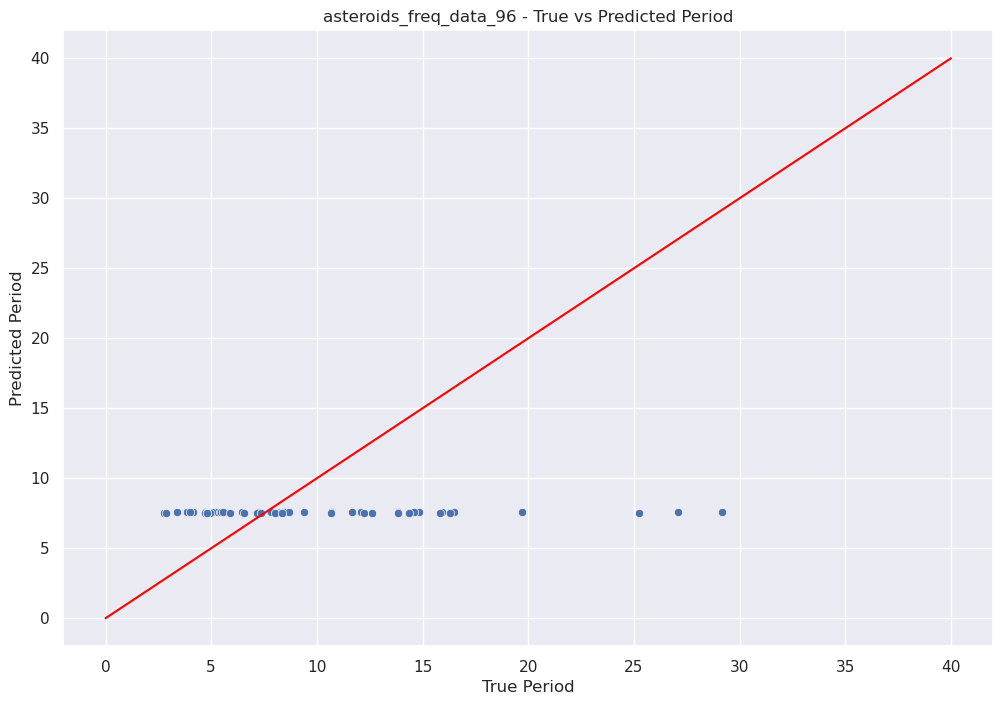

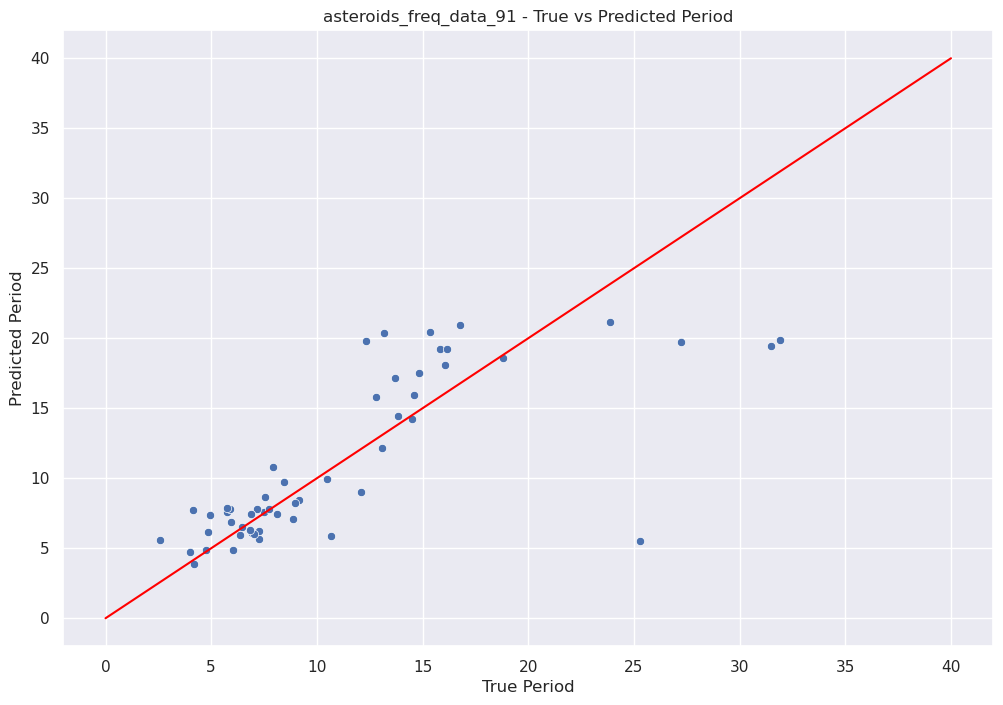

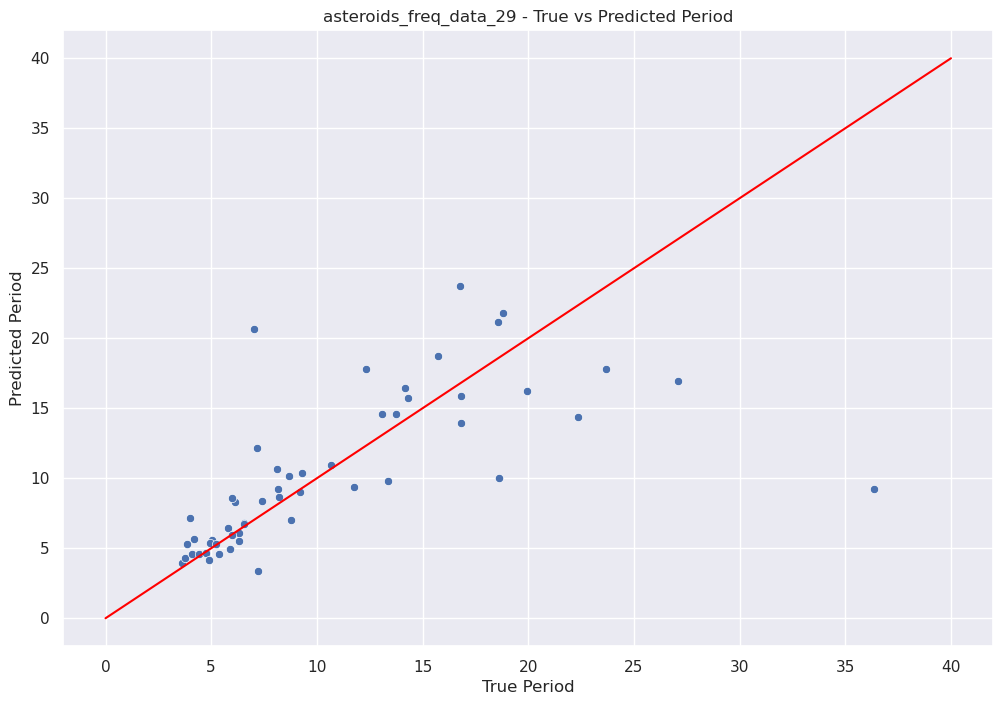

In [48]:
results = []
for feature_file in top_dataset_files:
    test_loss, test_r2, test_mae, test_preds, test_targets = train_and_predict(feature_file, verbose=False)  # type: ignore
    results.append([test_loss, test_r2, test_mae])

    sns.scatterplot(x=24 / np.array(test_targets), y=24 / np.array(test_preds))
    sns.lineplot(x=[0, 40], y=[0, 40], color="red")
    plt.xlabel("True Period")
    plt.ylabel("Predicted Period")
    plt.title(f"{feature_file.stem} - True vs Predicted Period")

    plt.show()


In [50]:
for test_loss, test_r2, test_mae in results:
    print(f"Test-loss: {test_loss:.4f}, Test-R2: {test_r2:.4f}, Test-MAE: {test_mae:.4f}")

Test-loss: 1.1300, Test-R2: 0.6900, Test-MAE: 0.6412
Test-loss: 1.0743, Test-R2: 0.7055, Test-MAE: 0.6137
Test-loss: 3.7890, Test-R2: 0.0086, Test-MAE: 1.4556
Test-loss: 1.6426, Test-R2: 0.5499, Test-MAE: 0.6553
Test-loss: 1.0885, Test-R2: 0.6719, Test-MAE: 0.6445
